# Example usage of the Lakeshore Model 372 to control the temperature of the Bluefors fridge
The Model 372 is used to control the temperature of the Bluefors fridges. To use it as such outside of the control software provided by Bluefors one has to establish an addtional connection. Within the Bluefors system, the lakeshore is connected via its usb port (through a USB hub along with the other devices) to the control Laptop (as part of the Bluefors setup). To control the temperature of the fridge via QCoDeS it is most convenient to connect the Lakeshore via its LAN port to the control computer (QCoDeS not Bluefors). For this the Bluefors rack has to be opened (Don't disconnect USB). Remember to set the IP address setting to DHCP (of course only when using a router).

For using the Lakeshore with qcodes, the operation mode has to be switched from USB to LAN. When done with the measurements please switch back to USB, so that the logging of the Temperature provided by the Bluefors software continues.
We are already planning to implement a server that takes care of the logging so that switching will no longer be necessary. For the time being please always remember to switch back!

### Driver Setup
This notebook is using a simulated version of the driver so that it can be run and played with, without an actual instrument. When trying it out with a real Lakeshore, please set `simulation = False`.

**Be careful, this notebook has not been tested with a real device yet!**

In [1]:
simulation = False

In [2]:
# close instrument if it exists already, for convenience
if 'ls' in globals():
    ls.close()

if simulation:
    from qcodes.tests.drivers.test_lakeshore import Model_372_Mock as Model_372
    import qcodes.instrument.sims as sims
    visalib = sims.__file__.replace('__init__.py',
                                    'lakeshore_model372.yaml@sim')
    ls = Model_372('lakeshore_372', 'GPIB::3::65535::INSTR',
                    visalib=visalib, device_clear=False)
else:
    from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
    ls = Model_372('lakeshore_372', 'TCPIP0::192.168.0.160::7777::SOCKET')

Connected to: LSCI 372 (serial:LSA21E7, firmware:1.3) in 0.18s


### Readout Sensor Channels
The lakeshore has two types of *channels*: *Readout channels* and *heaters*. For reading the temperature we use the readout channels. There are seventeen channels each of which has the following parameters:

In [3]:
sorted(ls.ch01.parameters.keys())

['auto_range',
 'current_source_shunted',
 'curve_number',
 'dwell',
 'enabled',
 'excitation_mode',
 'excitation_range_number',
 'pause',
 'range',
 'sensor_name',
 'sensor_raw',
 'sensor_status',
 't_limit',
 'temperature',
 'temperature_coefficient',
 'units']

In [4]:
ls.ch09.units('kelvin')

In [5]:
ls.ch03.enabled(False)

to read all temperatures we can do the following:

In [6]:
for ch in ls.channels:
    print(f'Temperature of {ch.short_name} ({"on" if ch.enabled() else "off"}, units={ch.units()}): {ch.temperature()} ({ch.pause()}, {ch.dwell()})')

Temperature of ch01 (off, units=kelvin): 37.6777 (3, 7)
Temperature of ch02 (off, units=kelvin): 2.70778 (3, 7)
Temperature of ch03 (off, units=kelvin): 3.62228 (3, 7)
Temperature of ch04 (off, units=kelvin): 0.0 (3, 7)
Temperature of ch05 (off, units=kelvin): 0.818951 (3, 7)
Temperature of ch06 (off, units=kelvin): 0.01003 (3, 3)
Temperature of ch07 (off, units=kelvin): 0.0 (3, 7)
Temperature of ch08 (off, units=kelvin): 0.0 (3, 7)
Temperature of ch09 (on, units=kelvin): 0.0198907 (3, 3)
Temperature of ch10 (off, units=kelvin): 0.0 (3, 10)
Temperature of ch11 (off, units=kelvin): 0.0 (3, 10)
Temperature of ch12 (off, units=kelvin): 0.0 (3, 10)
Temperature of ch13 (off, units=kelvin): 0.0 (3, 10)
Temperature of ch14 (off, units=kelvin): 0.0 (3, 10)
Temperature of ch15 (off, units=kelvin): 0.0 (3, 10)
Temperature of ch16 (off, units=kelvin): 0.0 (3, 10)


### Heating and Feedback
To set a certain temperature one needs to start a feedback loop that reads the temperature of a channel and feeds back to the sample through a heater. The lakeshore has three heaters: `sample_heater`, `warmup_heater`, and `analog_heater`.

Here the `sample_heater` will be used. It has the following parameters:

In [7]:
h = ls.sample_heater
sorted(h.parameters.keys())

['D',
 'I',
 'P',
 'blocking_T',
 'delay',
 'input_channel',
 'mode',
 'output_range',
 'polarity',
 'powerup_enable',
 'range_limits',
 'setpoint',
 'use_filter',
 'wait_cycle_time',
 'wait_equilibration_time',
 'wait_tolerance']

The allowed modes, polarities, and ranges are defined in:

In [8]:
h.MODES

{'closed_loop': 5,
 'monitor_out': 1,
 'off': 0,
 'open_loop': 2,
 'still': 4,
 'warm_up': 6,
 'zone': 3}

In [9]:
h.RANGES

{'100mA': 8,
 '100μA': 2,
 '10mA': 6,
 '1mA': 4,
 '3.16mA': 5,
 '31.6mA': 7,
 '31.6μA': 1,
 '316μA': 3,
 'off': 0}

In [10]:
h.POLARITIES

{'bipolar': 1, 'unipolar': 0}

For the PID mode we need to set the P, I, and D constants, the setpoint and the heater range, and start the operation by setting mode to 'closed_loop'

In [17]:
h.P(10)
h.I(20)
h.D(0)
h.output_range('100μA')  # 20mK ~30% of 316uA range
h.input_channel(9)

In [18]:
h.setpoint(0.020)
h.mode('closed_loop')

Now we can observe how the temperature gets steered towards the setpoint: (This is not implemented in the simulated instrument)

Text(value='')

<IPython.core.display.Javascript object>


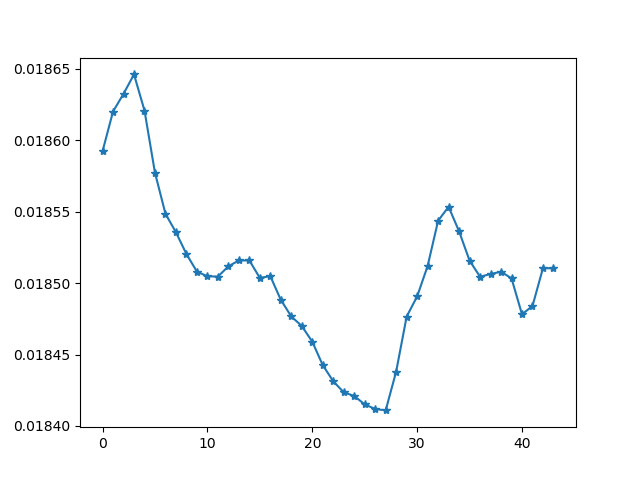

KeyboardInterrupt: 

In [16]:
%matplotlib notebook

import time
import numpy
from IPython.display import display
from ipywidgets import interact
from ipywidgets import widgets
from matplotlib import pyplot as plt

text = widgets.Text()
display(text)

fig, ax = plt.subplots(1)
line, = ax.plot([], [], '*-')
fig.show()
plt.ion()

for i in range(1000):
    time.sleep(0.2)
    text.value = f'{i} .. T={ls.ch09.temperature()}'
    
    line.set_ydata(numpy.append(line.get_ydata(), ls.ch09.temperature()))
    line.set_xdata(numpy.arange(0, len(line.get_ydata()), 1))
    
    ax.relim()        # Recalculate limits
    ax.autoscale_view(True,True,True) #Autoscale
    
    fig.canvas.draw()

In [ ]:
h.ouput_

### Waiting to reach setpoint
As we have seen, the call of the parameter `setpoint` is non-blocking. That means the function returns imediately without waiting for the setpoint to be reached. In many use-cases it is desirable to wait until a certain temperature regime has been reached. This can be achieved with `wait_until_set_point_reached()`. 

In [22]:
# wait half a second, then read the temperature and compare to setpoint
h.wait_cycle_time(0.3)
# wait until temperature within 5% of the setpoint
# the tolerance is defined as: |t_reading-t_setpoint|/t_reading
h.wait_tolerance(0.1)
# wait until temperature has been within the tolerance regime for `wait_equilibration_time` seconds
h.wait_equilibration_time(0.9)

import qcodes, logging

loggg = qcodes.instrument_drivers.Lakeshore.lakeshore_base.log
loggg.setLevel(logging.DEBUG)

with qcodes.utils.helpers.LogCapture(qcodes.instrument_drivers.Lakeshore.lakeshore_base.log) as logs:

# do the waiting:
# !! does not work with simulated instrument !!
    h.wait_until_set_point_reached()
    
print(logs.value)

loop iteration with t reading of 0.0178904, delta 0.1179179895362876
delta (0.1179179895362876) is not within wait_tolerance (0.1)
loop iteration with t reading of 0.0179069, delta 0.11688790354556068
delta (0.11688790354556068) is not within wait_tolerance (0.1)
loop iteration with t reading of 0.0179003, delta 0.1172997100607252
delta (0.1172997100607252) is not within wait_tolerance (0.1)
loop iteration with t reading of 0.0178938, delta 0.11770557399769746
delta (0.11770557399769746) is not within wait_tolerance (0.1)
loop iteration with t reading of 0.0178855, delta 0.11822425987531811
delta (0.11822425987531811) is not within wait_tolerance (0.1)
loop iteration with t reading of 0.0178793, delta 0.11861202619789363
delta (0.11861202619789363) is not within wait_tolerance (0.1)
loop iteration with t reading of 0.017873, delta 0.11900632238572151
delta (0.11900632238572151) is not within wait_tolerance (0.1)
loop iteration with t reading of 0.0178829, delta 0.11838683882368073
delt

** Simulation **

In case of a simulation we can fake the heating of the sample by calling the `start_heating` method (which only exists for the simulated instrument)

In [19]:
if simulation:
    ls.sample_heater.setpoint(4)
    ls.start_heating()
    ls.sample_heater.wait_until_set_point_reached()

loop iteration with t reading of 6.998815100000002
loop iteration with t reading of 6.476926400000025
loop iteration with t reading of 5.936238600000024
loop iteration with t reading of 5.334502799999996
loop iteration with t reading of 4.831042600000046
loop iteration with t reading of 4.33076410000001
loop iteration with t reading of 4.0
loop iteration with t reading of 4.0
loop iteration with t reading of 4.0
loop iteration with t reading of 4.0
loop iteration with t reading of 4.0


### Automatically selecting a heater range
To automatically select a heater range one can define temperature limits for the individual heater ranges:

In [23]:
# all limits in K, 7 limits starting with limit for 31.6μA
h.range_limits([0.021, 0.1, 0.2, 1.1, 2, 4, 8])

this means: from 0 K to 0.021 K use 31.6μA, from 0.021 K to 0.1 K use 100μA and so on

we can now set the range by giving a temperature:

In [25]:
h.set_range_from_temperature(0.15)
h.output_range()

'316μA'

### Sweeping/blocking paramameter
For compatibility with the legacy loop construct the lakeshore driver exposes a blocking temperature parameter: `blocking_T`.
The setter for this parameter simply does:

```
def _set_blocking_T(self, T):
     self.set_range_from_temperature(T)
     self.setpoint(T)
     self.wait_until_set_point_reached()
```

This parameter can be used in a doNd loop.

** the range only gets set at the beginning of the sweep, i.e. according to the setpoint not according to the temperature reading **

